
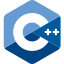
<br>

<div style="text-align:center; font-size:200%;">
  <b>SOLID: Dependency Inversion Principle</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 12 SOLID Dependency Inversion Principle.ipynb -->
<!-- slides/module_500_solid_grasp/topic_400_solid_dip.cpp -->

<!--
clang-format on
-->


# Dependencies

- We have to distinguish two kinds of dependencies:
  - Data and control flow
  - Source code dependencies
- Data and control flow dependencies are inherent in the logic
- Source code dependencies can be controlled by the architecture


## Example

- Module `MyModule.cpp` writes data to a database
- Data flow: from `MyModule.cpp` to the database
- Source code dependency: `MyModule.cpp` depends on the database (`Database.h`)


Module `MyModule.cpp`:

In [ ]:
#include <string>
#include <vector>
#include <xcpp/xdisplay.hpp>

#include "Database.h"

In [ ]:
class MyDomainClassV1
{
public:
    void PerformWork(std::string data)
    {
        data = "Processed: " + data;
        db.Execute("INSERT INTO my_table VALUES (?)", data);
    }

    std::vector<std::string> RetrieveResult()
    {
        return db.Execute("SELECT * FROM my_table");
    }

private:
    Database db;
};

In [ ]:
MyDomainClassV1 myDomainObjectV1{};

In [ ]:
myDomainObjectV1.PerformWork("Hello World");

In [ ]:
xcpp::display(myDomainObjectV1.RetrieveResult());


The source code dependency goes in the same direction as the data flow:

`MyModule.cpp` ⟹ `Database.h`

<img src="img/db-example-01.svg"
     style="display:block;margin:auto;width:75%"/>


We would like to avoid such dependencies in the core of our application

- Easier to test
- Easier to extend
- Easier to replace external dependencies
- Easier to understand the code
- ...


<img src="img/db-example-02.svg"
     style="display:block;margin:auto;width:75%"/>


- Module `MyModule.cpp`:
  - No more dependency to `Database.h`
  - Adapter Pattern

In [ ]:
class AbstractDatabaseAdapter
{
public:
    AbstractDatabaseAdapter() = default;
    virtual ~AbstractDatabaseAdapter() = default;

    virtual void SaveObject(std::string data) = 0;
    virtual std::vector<std::string> RetrieveData() = 0;
};

In [ ]:
class MyDomainClassV2
{
public:
    MyDomainClassV2(std::unique_ptr<AbstractDatabaseAdapter> db) : db_{std::move(db)} {}

    void PerformWork(std::string data)
    {
        data = "Processed: " + data;
        db_->SaveObject(data);
    }

    std::vector<std::string> RetrieveResult() { return db_->RetrieveData(); }

private:
    std::unique_ptr<AbstractDatabaseAdapter> db_;
};


- Module `ConcreteDatabaseAdapter.cpp/.h`:
  - Implements `AbstractDatabaseAdapter` for `Database.h`
  - Depends on `Database.h`

In [ ]:
#include "Database.h"

In [ ]:
class ConcreteDatabaseAdapter : public AbstractDatabaseAdapter
{
public:
    void SaveObject(std::string data) override
    {
        db_.Execute("INSERT INTO my_table VALUES (?)", data);
    }

    std::vector<std::string> RetrieveData() override
    {
        return db_.Execute("SELECT * FROM my_table");
    }

private:
    Database db_;
};


- Module `main.cpp`:

In [ ]:
// #include "ConcreteDatabaseAdapter.h"
// #include "MyDomainClassV2.h"

In [ ]:
auto dbAdapter{std::make_unique<ConcreteDatabaseAdapter>()};
MyDomainClassV2 myDomainObjectV2{std::move(dbAdapter)};

In [ ]:
myDomainObjectV2.PerformWork("Hello World");

In [ ]:
xcpp::display(myDomainObjectV2.RetrieveResult());


# SOLID: Dependency Inversion Principle

- The core functionality of a system does not depend on its environment
  - **Concrete artifacts depend on abstractions** (not vice versa)
  - **Unstable artifacts depend on stable artifacts** (not vice versa)
  - **Outer layers** of the architecture **depend on inner layers** (not vice
    versa)
  - Classes/Modules depend on abstractions (e.g., interfaces) not on other
    classes/modules
- Dependency inversion achieves this by introducing interfaces that “reverse
  the dependencies”


### Before
<img src="img/dependency-01.svg"
     style="display:block;margin:auto;width:75%"/>

### After
<img src="img/dependency-02.svg"
     style="display:block;margin:auto;width:75%"/>


<img src="img/dip-01.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-02.svg"
     style="display:block;margin:auto;width:95%"/>


<img src="img/dip-03.svg"
     style="display:block;margin:auto;width:95%"/>


## Workshop: Weather Report

We have written a program that retrieves a weather report from a server.
Unfortunately, the dependency to the server of type `LegacyWeatherServer` is
hard-coded. Due to the popularity of the program, we now have to become
compatible with a new type of server `NewWeatherServer`. To do this, we
refactor the code according to the Dependency Inversion Principle and then
implement an additional adapter for `NewWeatherServer`.

- Introduce an abstraction to reverse the dependency
- Write a concrete implementation of the abstraction for
  `LegacyWeatherServer`
- Test the implementation
- Implement an adapter for `NewWeatherServer`
- Test the adapter

In [ ]:
#include <iostream>
#include <random>
#include <string>
#include <tuple>
#include <vector>

In [ ]:
class WeatherReport
{
public:
    WeatherReport(double temperature, double humidity)
        : temperature_{temperature}, humidity_{humidity}
    {}

    double GetTemperature() const { return temperature_; }
    double GetHumidity() const { return humidity_; }

private:
    double temperature_;
    double humidity_;
};

In [ ]:
class LegacyWeatherServer
{
public:
    WeatherReport GetWeatherReport()
    {
        static std::random_device rd;
        static std::mt19937 gen{rd()};
        static std::uniform_real_distribution<> dis{0.0, 1.0};
        return WeatherReport{20.0 + 10.0 * dis(gen), 0.5 + 0.5 * dis(gen)};
    }
};

In [ ]:
class NewWeatherServer
{
public:
    std::tuple<double, double> FetchWeatherData()
    {
        static std::random_device rd;
        static std::mt19937 gen{rd()};
        static std::uniform_real_distribution<> dis{0.0, 1.0};
        return {10.0 + 20.0 * dis(gen), 0.7 + 0.4 * dis(gen)};
    }
};

In [ ]:
class WeatherReporter
{
public:
    WeatherReporter(std::shared_ptr<LegacyWeatherServer> server)
        : server{std::move(server)}
    {}

    std::string Report()
    {
        WeatherReport report{server->GetWeatherReport()};
        if (report.GetTemperature() > 25.0f)
        {
            return "It's hot";
        }
        else
        {
            return "It's not hot";
        }
    }

private:
    std::shared_ptr<LegacyWeatherServer> server;
};

In [ ]:
std::shared_ptr<LegacyWeatherServer> server{std::make_shared<LegacyWeatherServer>()};
WeatherReporter reporter{server};

In [ ]:
xcpp::display(reporter.Report());